In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

from robmob import robot, sensors
from robmob.point_cloud import PointCloud
from time import sleep
import math

import numpy as np
import scipy
import scipy.ndimage

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('nbagg')
from matplotlib import cm

robot_ip = '192.168.0.112'
robot = robot.Robot(robot_ip)
robot.connect()

In [2]:
depth_image = scipy.ndimage.imread("./img/depth_g.png") / 100.0 #Assume that depth_image contains distances in mm
height, width = depth_image.shape
# Intrinsic parameters:
# field of view
fov_x, fov_y = (365.456, 365.456)
# principal point
center_x, center_y = (254.878, 205.395)

In [3]:
def to_points(depth_image, color_image=None):
    height, width = depth_image.shape

    theta_x = np.arctan((np.arange(width) - center_x) / fov_x)
    theta_y = np.arctan((np.arange(height) - center_y) / fov_y)
    theta_x = np.expand_dims(theta_x, axis=0) # Row matrix
    theta_y = np.expand_dims(theta_y, axis=1) # Column matrix

    dx = depth_image * np.cos(theta_x)
    dy = depth_image * np.cos(theta_y)

    x = dx * np.sin(theta_x)
    y = dy * np.sin(theta_y)
    z = depth_image

    x_column = np.reshape(x, (-1, 1))
    y_column = np.reshape(y, (-1, 1))
    z_column = np.reshape(z, (-1, 1))
    
    points = np.hstack((x_column, y_column, z_column))
    
    #Removes rows where the z value is 0
    points_to_keep_mask = ~(abs(points) < 1e-6)[:,2]
    points = points[points_to_keep_mask]
    
    if color_image is not None:
        colors = np.asarray(color_image).reshape((-1, 3))
        colors = colors[points_to_keep_mask]
        return points, colors
    else:
        return points

### To view the point cloud

[link](point_cloud/viewer.html)

In [4]:
depth_sensor = sensors.KinectDepthSensor()
rgb_sensor = sensors.KinectRGBSensor()
robot.add_sensor(depth_sensor)
robot.add_sensor(rgb_sensor)

<IPython.core.display.Javascript object>


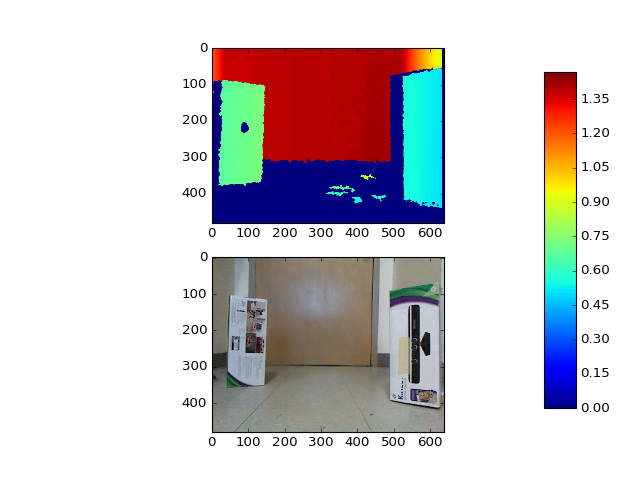

In [6]:
buffer_depth = depth_sensor.read_data()
buffer_rgb = rgb_sensor.read_data()
fig, (ax1, ax2) = plt.subplots(2, 1)

im1 = ax1.imshow(buffer_depth, aspect='equal')
im2 = ax2.imshow(buffer_rgb, aspect='equal')

cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im1, cax=cbar_ax)

plt.show()

In [34]:
points, colors = to_points(buffer_depth, buffer_rgb)

In [35]:
PointCloud(points, colors).save()

# Ransac

In [8]:
def find_plane_ransac(points, n_trials=1000, epsilon=1e-2):
    best_inliers, best_n_inliers = None, 0
    for _ in range(n_trials):
        #Select three points - the minimum number of points that define a plane
        plane_points = points[np.random.choice(points.shape[0], 3, replace=False)]

        #Define the plane by a unit vector
        normal_vector = np.cross(plane_points[1] - plane_points[0], plane_points[2] - plane_points[0])
        normal_unit_vector = normal_vector / np.linalg.norm(normal_vector)

        #Compute distances from plane
        distances = np.dot((points - plane_points[0]), normal_unit_vector)

        #Find inliers
        inliers = abs(distances) < epsilon
        n_inliers = np.count_nonzero(inliers)
        
        if n_inliers > best_n_inliers:
            best_inliers, best_n_inliers = inliers, n_inliers

    return best_inliers, best_n_inliers
    

In [38]:
inliers, n_inliers = find_plane_ransac(p, 100, epsilon=2e-2)

points_of_plane = p[inliers]
points_of_plane_colors = np.tile(np.array([255, 0 , 0], dtype=np.uint8), (n_inliers, 1))

other_points = p[~inliers]
other_points_colors = colors[~inliers]

all_points = np.vstack((points_of_plane, other_points))
all_colors = np.vstack((points_of_plane_colors, other_points_colors))
all_points.shape

(202986, 3)

In [39]:
PointCloud(all_points, all_colors).save()

In [11]:
def color_n_planes(points, n, ransac_params={}):
    colored_points, colors = None, None
    remaining_points = points
    
    for i in range(n):
        inliers, n_inliers = find_plane_ransac(remaining_points, **ransac_params)
        points_of_plane = remaining_points[inliers]
        remaining_points = remaining_points[~inliers]
        
        random_color = np.random.randint(100, 200, size=[3], dtype=np.uint8)
        new_colors = np.tile(random_color, (n_inliers, 1))
        
        if colored_points is not None:
            colored_points = np.vstack((colored_points, points_of_plane))
            colors = np.vstack((colors, new_colors))
        else:
            colored_points = points_of_plane
            colors = new_colors
    
        if remaining_points.shape[0] < 3:
            break
        
    return colored_points, colors

In [40]:
pc, cc = color_n_planes(all_points, 3, ransac_params={'n_trials': 50, 'epsilon': 2e-2})

In [41]:
PointCloud(pc, cc).save()